[View in Colaboratory](https://colab.research.google.com/github/pacifinapacific/DCGAN/blob/master/Untitled0.ipynb)

In [19]:
#google-drive-ocamlfuseのインストール
#https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

gpg: keybox '/tmp/tmp705d3051/pubring.gpg' created
gpg: /tmp/tmp705d3051/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.0)


In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = '10s0ovxI02urpK7CH3wQWdtXhAH8qrz1H'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('SuperResolution.zip')

In [6]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b136000 @  0x7fee4bb091c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [20]:
!ls

drive  lfw-deepfunneled


In [8]:
!unzip SuperResolution.zip

Archive:  SuperResolution.zip
   creating: SuperResolution/
  inflating: SuperResolution/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/SuperResolution/
  inflating: __MACOSX/SuperResolution/._.DS_Store  
   creating: SuperResolution/asset/
   creating: SuperResolution/dataset/
  inflating: SuperResolution/SRGAN.ipynb  
   creating: SuperResolution/lfw-deepfunneled/
  inflating: SuperResolution/lfw-deepfunneled/.DS_Store  
   creating: __MACOSX/SuperResolution/lfw-deepfunneled/
  inflating: __MACOSX/SuperResolution/lfw-deepfunneled/._.DS_Store  
   creating: SuperResolution/lfw-deepfunneled/test/
   creating: SuperResolution/lfw-deepfunneled/test/Xiang_Huaicheng/
  inflating: SuperResolution/lfw-deepfunneled/test/Xiang_Huaicheng/Xiang_Huaicheng_0001.jpg  
   creating: __MACOSX/SuperResolution/lfw-deepfunneled/test/
   creating: __MACOSX/SuperResolution/lfw-deepfunneled/test/Xiang_Huaicheng/
  inflating: __MACOSX/SuperResolution/lfw-deepfunneled/test/Xiang_Huaicheng/._Xiang_Hu

In [18]:
!ls

lfw-deepfunneled


In [10]:
cd SuperResolution

/content/SuperResolution


In [0]:
!mv  lfw-deepfunneled ~

In [2]:
!ls 

adc.json  drive  __MACOSX  sample_data	SuperResolution  SuperResolution.zip


In [5]:
cd ~

/root


In [5]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [1]:
cd SuperResolution

/content/SuperResolution


In [2]:
!mv  lfw-deepfunneled ~

mv: cannot stat 'lfw-deepfunneled': No such file or directory


In [3]:
cd ~

/root


In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
%matplotlib inline
from torchvision.models.vgg import vgg16
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists("drive/save_image"):
    os.mkdir("drive/save_image")
if not os.path.exists("drive/dataset"):
    os.mkdir("drive/dataset")
if not os.path.exists("drive/asset"):
    os.mkdir("drive/asset")

cuda is available!


In [0]:
class DownSizePairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=256, small_size=64, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Scale(large_size)
        self.small_resizer = transforms.Scale(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        return small_img, large_img

In [6]:
train_data = DownSizePairImageFolder('./lfw-deepfunneled/train', transform=transforms.ToTensor())
test_data = DownSizePairImageFolder('./lfw-deepfunneled/test', transform=transforms.ToTensor())
batch_size = 48
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [7]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


ModuleNotFoundError: ignored

torch.Size([3, 256, 256])
1.0 0.0


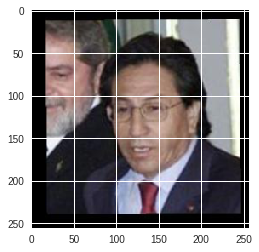

In [8]:
#print( train_data.class_to_idx)
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
1.0 0.0


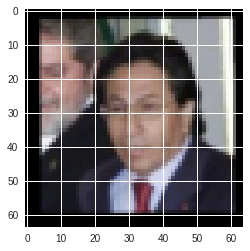

In [9]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

In [0]:
class Generator(nn.Module):
    def __init__(self,image_size):
        super(Generator,self).__init__()
        self.image_size=image_size
        
        self.pre_layer=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU())
        
        self.residual_layer=nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64))
        
        self.middle_layer=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64))
        
        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4))
    def forward(self,input_image):
        pre=self.pre_layer(input_image)
        res=self.residual_layer(pre)
        middle=self.middle_layer(res)
        middle=middle+pre
        output=self.pixcelshuffer_layer(middle)
        
        return output
        

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel))
    def forward(self,x):
        residual=self.residualblock(x)
        
        return x+residual

In [0]:
class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU())
    def forward(self,x):
        return self.layer(x)

In [13]:
test_input=torch.ones(1,3,64,64)
g=Generator(64)
if cuda:
    test_input=test_input.cuda()
    g=g.cuda()
out=g(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))#(512,316,16)
        
        self.dense_layer=nn.Sequential(
            nn.Linear(16*16*512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid())
        
    def forward(self,input_image):
        batch_size=input_image.size()[0]
        
        conv=self.conv_layers(input_image)
        reshape=conv.view(batch_size,-1)
        output=self.dense_layer(reshape)
        
        return output


In [15]:
test_input=torch.ones(1,3,256,256)
d=Discriminator()
if cuda:
    test_input=test_input.cuda()
    d=d.cuda()
out=d(test_input)
print(out.size())

torch.Size([1, 1])


In [0]:
def generator_loss(generated_image,hr_image,d_label,t_label):
    vgg=vgg16(pretrained=True)
    content_layers=nn.Sequential(*list(vgg.features)[:31]).cuda().eval()
    for param in content_layers.parameters():
        param.requires_grad=False
    
    mse_loss=nn.MSELoss()
    content_loss=mse_loss(content_layers(generated_image),content_layers(hr_image))
    
    BCE_loss=nn.BCELoss()
    adversarial_loss=BCE_loss(d_label,t_label)
    
    return content_loss,0.001*adversarial_loss
    

In [0]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss,self).__init__()
    vgg=vgg16(pretrained=True)
    content_layers=nn.Sequential(*list(vgg.features)[:31]).cuda().eval()
    for param in content_layers.parameters():
        param.requires_grad=False
    self.content_layers=content_layers
    self.mse__loss=nn.MSELoss()
  def forward(generated_image,hr_image,d_label,t_label):
    adversarial_loss=BCE_loss(d_label,t_label)
    content_loss=self.mse_loss(self.content_layers(generated_image),self.content_layers(hr_image))
    return content_loss,0.001*adversarial_loss

In [0]:
G=Generator(64)
D=Discriminator()

if cuda:
    G=G.cuda()
    D=D.cuda()
G_optimizer=optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))
D_optimizer=optim.Adam(D.parameters(),lr=0.0001,betas=(0.9,0.999))

d_loss=nn.BCELoss()
#Generator_Loss=GeneratorLoss()

In [0]:
def train(epoch):
    D.train()
    G.train()
    
    y_real=torch.ones(batch_size,1)
    y_fake=torch.zeros(batch_size,1)
    
    if cuda:
        y_real=y_real.cuda()
        y_fake=y_fake.cuda()
        
        D_loss=0
        G_loss=0
        
    for batch_idx,(data_lr,data_hr)in enumerate(train_loader):
        if data_lr.size()[0]!=batch_size:
            break
        if cuda:
            data_lr=data_lr.cuda()
            data_hr=data_hr.cuda()
        print(batch_idx)
        #D_optimizer.zero_grad()
        D.zero_grad()
        
        D_real=D(data_hr)
        D_real_loss=d_loss(D_real,y_real)
        
        fake_image=G(data_lr)
        D_fake=D(fake_image)
        D_fake_loss=d_loss(D_fake,y_fake)
        
        D_loss=D_real_loss+D_fake_loss
        D_loss.backward(retain_graph=True)
        D_optimizer.step()
        D_loss+=D_loss.data[0]
        
        #G_optimizer.zero_grad()
        G.zero_grad()
        
        content_loss,adversarial_loss=generator_loss(fake_image,data_hr,D_fake,y_real)
        print(content_loss)
        print(adversarial_loss)
        G_loss=content_loss+adversarial_loss
        #G_loss=Generator_loss(fake_image,data_hr,D_fake,y_real)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data[0]
        
        D_loss/=len(train_loader)
        G_loss/=len(train_loader)
        """"
        if batch_idx%10==0:
            g_image=fake_image.data.cpu()
            hr_image=data_hr.data.cpu()
            SR_image=torch.cat((hr_image,g_image),0)
            save_image(SR_image,"drive/save_image/epoch_{}_{}.png".format(epoch,batch_idx))
            print("save_image")
            #count+=1
        """
        return D_loss,G_loss

In [20]:
d_loss_list=[]
g_loss_list=[]
total_loss_list=[]
num_epoch=10000

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    d_loss_,g_loss_=train(epoch)
    total_loss=d_loss_+g_loss_
    print("epoch [{}/{}],--d_loss:{:.4f}--g_loss:{:.4f}--total_loss:{:.4f}".format(epoch,num_epoch,
                                                               d_loss_,g_loss_,total_loss))
    d_loss_list.append(d_loss_)
    g_loss_list.append(g_loss_)
    total_loss_list.append(total_loss)
    
    if epoch%1==0:
        #generate_image(epoch)
        torch.save(G.state_dict(),"drive/asset/G_epoch{}.pth".format(epoch))
        torch.save(D.state_dict(),"drive/asset/D_epoch{}.pth".format(epoch))
    
np.save("drive/asset/d_loss_list.npy",np.array(d_loss_list))
np.save("drive/asset/g_loss_list.npy",np.array(g_loss_list))
np.save("drive/asset/total_loss_list.npy",np.array(total_loss_list))

trainning start!!
0


RuntimeError: ignored

In [2]:
!nvidia-smi

Sat Aug 25 05:55:08 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    30W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [23]:
!nvidia-smi
!ps aux | grep python

Sat Aug 25 05:42:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    69W / 149W |  11059MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!kill -9 81

In [25]:
!ps aux|grep <username>|grep python|awk '{print $2}'|xargs kill

/bin/sh: 1: cannot open username: No such file

Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help and exit
 -V, --version  output version information and exit

For more details see kill(1).
